In [29]:
from BinaryFileUnpack import BinaryFileUnpack
import numpy as np
import tkinter as tk
from tkinter import filedialog
from matplotlib import pyplot as plt

# Kistler Lab Data Instrutions with <code>BinaryFileUnpack</code>
This Jupyter Notebook contains an example of the analysis methods in the <code>BinaryFileUnpack</code> module.

**Instructions**
1. Under the "Daily Calibration" cell, indicate which file should be used for the calibration of pressure data, along with the ambient pressure, indicated in the filename. The calibrated pressure data is stored in a new variable named <code>Pressure</code>, while the original pressure is in <code>analysis.P</code>.
    - If there is no such file, ignore the "Daily Calibration" and "Applying Calibration" cells. When plotting, replace variables named <code>Pressure</code> with <code>analysis.P</code>.
2. Select the <code>.bin</code> file corresponding to the experiment to analyze.
3. If there is a daily calibration, run the cell labeled "Apply Calibration."
4. Run whatever cell you desire!


When it comes to plotting, there are 2 options:
- <code>%matplotlib qt</code>: A Jupyter Notebook magic command that emulates running <code>Matplotlib</code> plots in a <code>.py</code> file. This option will open up a separate, interactive window for the graph, allowing you to select a range of data more flexibly.
- <code>%matplotlib inline</code>: A Jupyter Notebook magic command that displays plots within the notebook. While less flexible, it can handle plots containing more data better than the <code>%matplotlib qt</code> option.

Choose which option you want by commenting out the option you do not want!


## Daily Calibration

In [30]:
def daily_cali(fp:str, atm_pres):
    cali_file = BinaryFileUnpack(fp)
    pres_cali = np.mean(cali_file.P, axis=-1) - atm_pres
    return pres_cali

def apply_cali(analysis:BinaryFileUnpack, pres_cali):
    Pres = np.zeros(analysis.P.shape)
    for i in range(analysis.num_sens):
        Pres[i] = analysis.P[i] - pres_cali[i]
    return Pres

pres_cali_1025 = daily_cali(r"C:\Users\akyap\OneDrive\Documents\Academics\Research\LDEO Geysers\files\10-25\calibration_1019p01-20241025-10-14-35.bin", 1.01901)
pres_cali_1025

array([0.23600018, 0.26532394, 0.23475046, 0.24416186, 0.262539  ,
       0.16072059])

## Initializing BinaryFileUnpack object
Select the <code>.bin</code> file to analyze.

In [31]:
# Select the file to analyze
interactive_select = True

if interactive_select:
    root = tk.Tk()
    root.withdraw()
    filepath = filedialog.askopenfilename()
else:
    # Specify filepath
    filepath = r'HotWaterCycles_heaters_on_steam_in-20221118-20-09-42.bin'
print(filepath)

C:/Users/akyap/OneDrive/Documents/Academics/Research/LDEO Geysers/files/10-25/MidConstriction_Cone_Stage4-20241025-14-10-48.bin


In [32]:
analysis = BinaryFileUnpack(filepath, sens_from_header=True)
num_sens = analysis.num_sens
analysis.header_info

{'File Version': 3,
 'Sampling Rate': 10000.0,
 'Device Count': 3,
 'Device ID': array([0, 1, 2]),
 'Serial Number Length': array([7, 7, 7], dtype=uint32),
 'Serial Number': array([[53, 57, 53, 52, 56, 55, 56],
        [53, 57, 53, 52, 56, 55, 54],
        [53, 57, 53, 52, 56, 55, 55]]),
 'Name Length': array([7, 7, 7], dtype=uint32),
 'Name': array([[ 76,  97,  98,  65, 109, 112,  49],
        [ 76,  97,  98,  65, 109, 112,  50],
        [ 76,  97,  98,  65, 109, 112,  51]]),
 'Number of Enabled Channels': array([4, 4, 4], dtype=uint32),
 'Channel Number': array([[1, 2, 3, 4],
        [1, 2, 3, 4],
        [1, 2, 3, 4]])}

### Applying Calibration

In [33]:
Pressure = apply_cali(analysis, pres_cali_1025)
Pressure

array([[1.15026081, 1.15084934, 1.15059876, ..., 1.08296955, 1.08263171,
        1.08318758],
       [1.11598891, 1.11553114, 1.11512786, ..., 1.05654496, 1.05609816,
        1.05570572],
       [1.07885687, 1.07996862, 1.07888965, ..., 1.0429552 , 1.04276983,
        1.04314046],
       [1.02394162, 1.02401791, 1.02389799, ..., 1.02837764, 1.02978359,
        1.02910779],
       [1.03708485, 1.03710655, 1.03676871, ..., 1.03941718, 1.04038718,
        1.03952626],
       [1.01872933, 1.02003729, 1.01884925, ..., 1.02038598, 1.02059305,
        1.02028787]])

## Graphing PT data in Matplotlib (static)

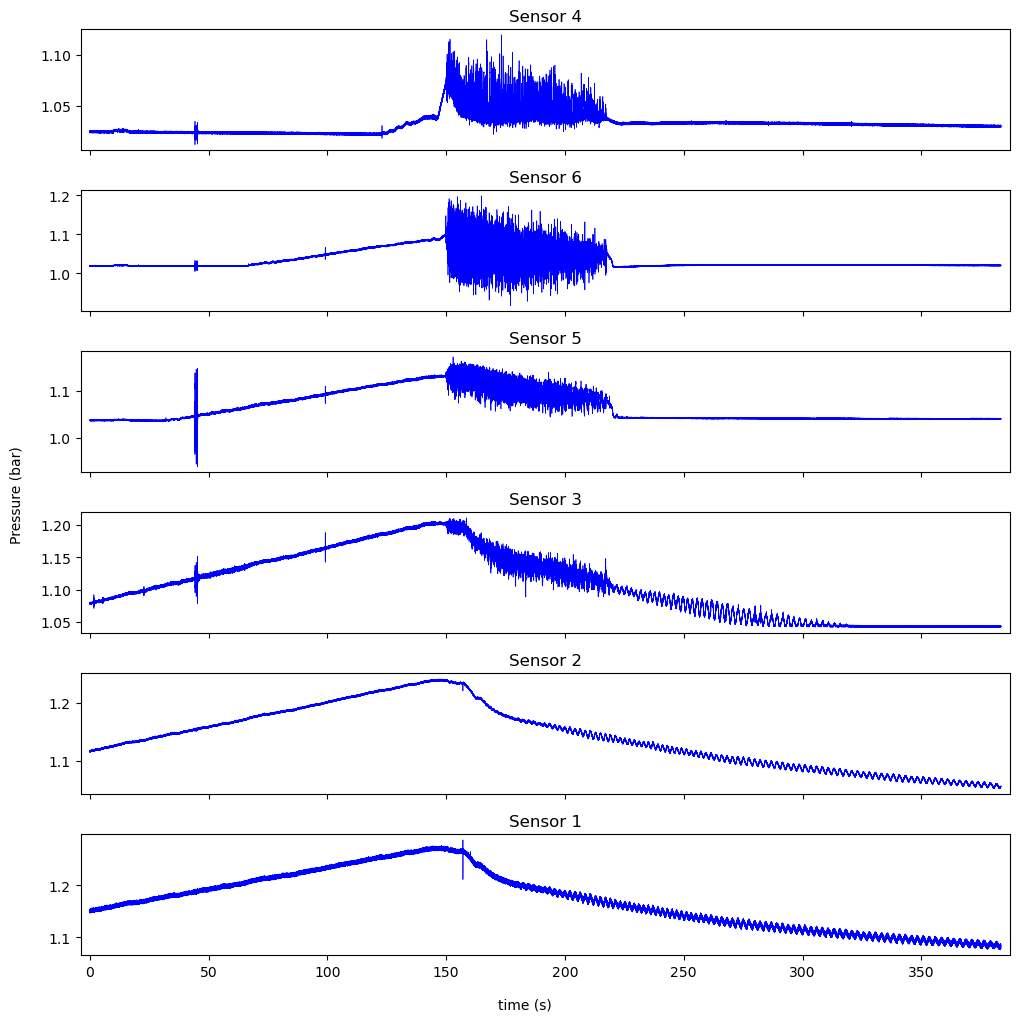

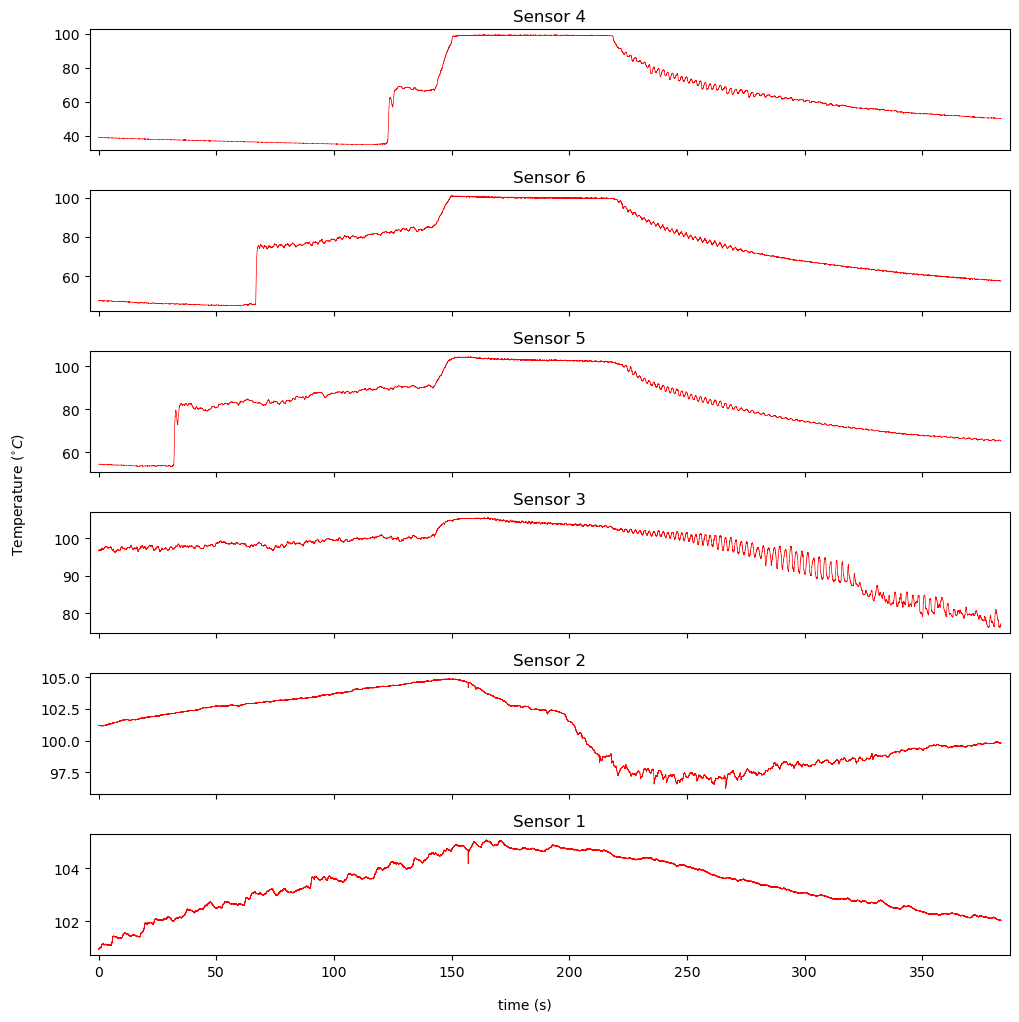

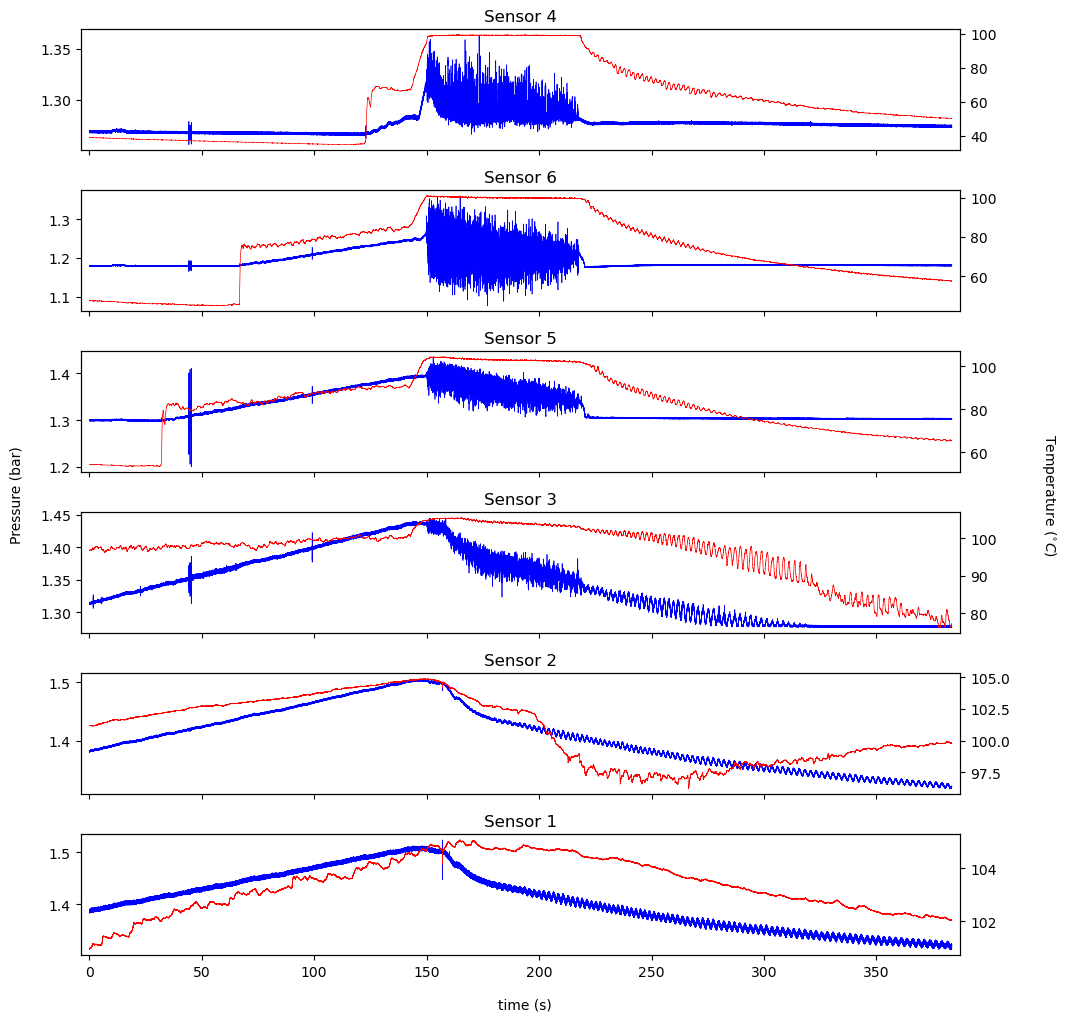

In [34]:
# %matplotlib qt
%matplotlib inline

sta = 0; end = len(analysis.time)/analysis.fs
times = analysis.getTimeRange(sta, end)
# Pressure
analysis.plot_static(analysis.time, Pressure, "time (s)", "Pressure (bar)", plots_shape=(num_sens, 1), color='b', times=times, ordering=[3, 5, 4, 2, 1, 0])
# Temperature
analysis.plot_static(analysis.time, analysis.T, "time (s)", r"Temperature ($^{\circ}C$)", plots_shape=(num_sens, 1), color='r', times=times, ordering=[3, 5, 4, 2, 1, 0])
# PT
analysis.plot_static(analysis.time, analysis.P, "time (s)", "Pressure (bar)", plots_shape=(num_sens, 1), times=times, y2 = analysis.T, ordering=[3, 5, 4, 2, 1, 0], y2_label=r"Temperature ($^{\circ}C$)", sharex=True)

Pressure on same axis, Temperature on same axis of all sensors

C:\Users\akyap\AppData\Local\Temp\ipykernel_26348\3274832897.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


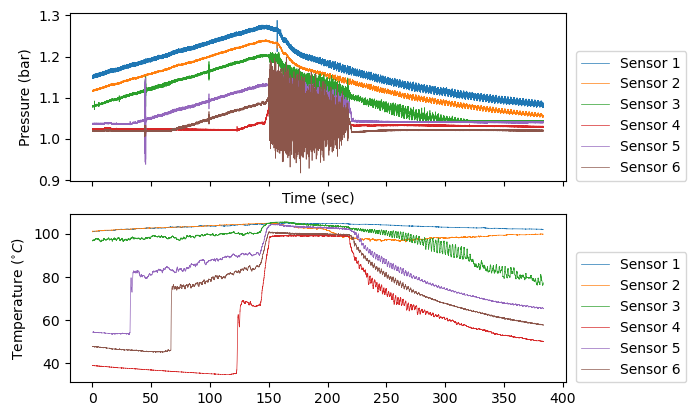

In [35]:
# %matplotlib qt
%matplotlib inline
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].set_xlabel("Time (sec)")
ax[0].set_ylabel("Pressure (bar)")
ax[1].set_ylabel(r"Temperature ($^{\circ}C$)")
for i in range(analysis.num_sens):
    ax[0].plot(analysis.time, Pressure[i], label=f"Sensor {i+1}", linewidth=0.5)
for i in range(analysis.num_sens):
    ax[1].plot(analysis.time, analysis.T[i], label=f"Sensor {i+1}", linewidth=0.5)
ax[0].legend(bbox_to_anchor=(1.02, 0), loc='lower left', borderaxespad=0.)
ax[1].legend(bbox_to_anchor=(1.02, 0), loc='lower left', borderaxespad=0.)
fig.show()

Same as above, but just with filtered Pressure data.

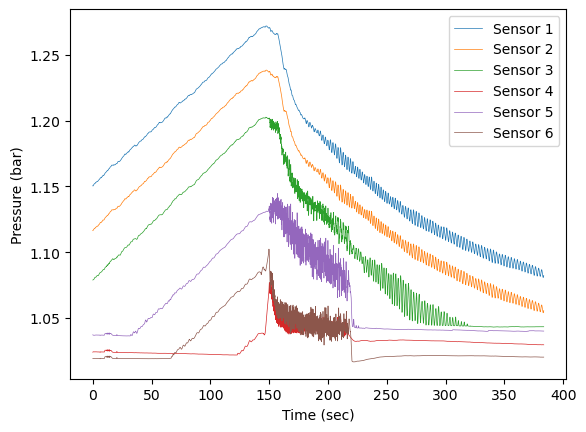

In [36]:
# %matplotlib qt
%matplotlib inline
import scipy.signal as signal
bound_freq = 2.2
nyq_freq = analysis.fs // 2
b, a = signal.butter(1, bound_freq/nyq_freq, 'lowpass')
for i in range(analysis.num_sens):
    plt.plot(analysis.time, signal.filtfilt(b, a, Pressure[i]), label=f"Sensor {i+1}", linewidth=0.5)
plt.legend()
plt.xlabel("Time (sec)")
plt.ylabel("Pressure (bar)")
plt.show()

## Simple Spectral Analysis
For a more involved spectral analysis, run the "Spectogram cells." This gives the spectra of the entire data.

Obtaining spectra

In [40]:
# Pressure
Pxx = analysis.spectra(Pressure)
# Temperature
Txx = analysis.spectra(analysis.T)

c:\Users\akyap\OneDrive\Documents\Academics\Research\LDEO Geysers\files\python\BinaryFileUnpack.py:292: FutureWarning: Soon to be depreciated
  warnings.warn("Soon to be depreciated", FutureWarning)


Plotting Spectra (buggy)

c:\Users\akyap\OneDrive\Documents\Academics\Research\LDEO Geysers\files\python\BinaryFileUnpack.py:465: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[i][j].set_xlim((np.min(times) - duration*0.01, np.max(times) + duration*0.01))


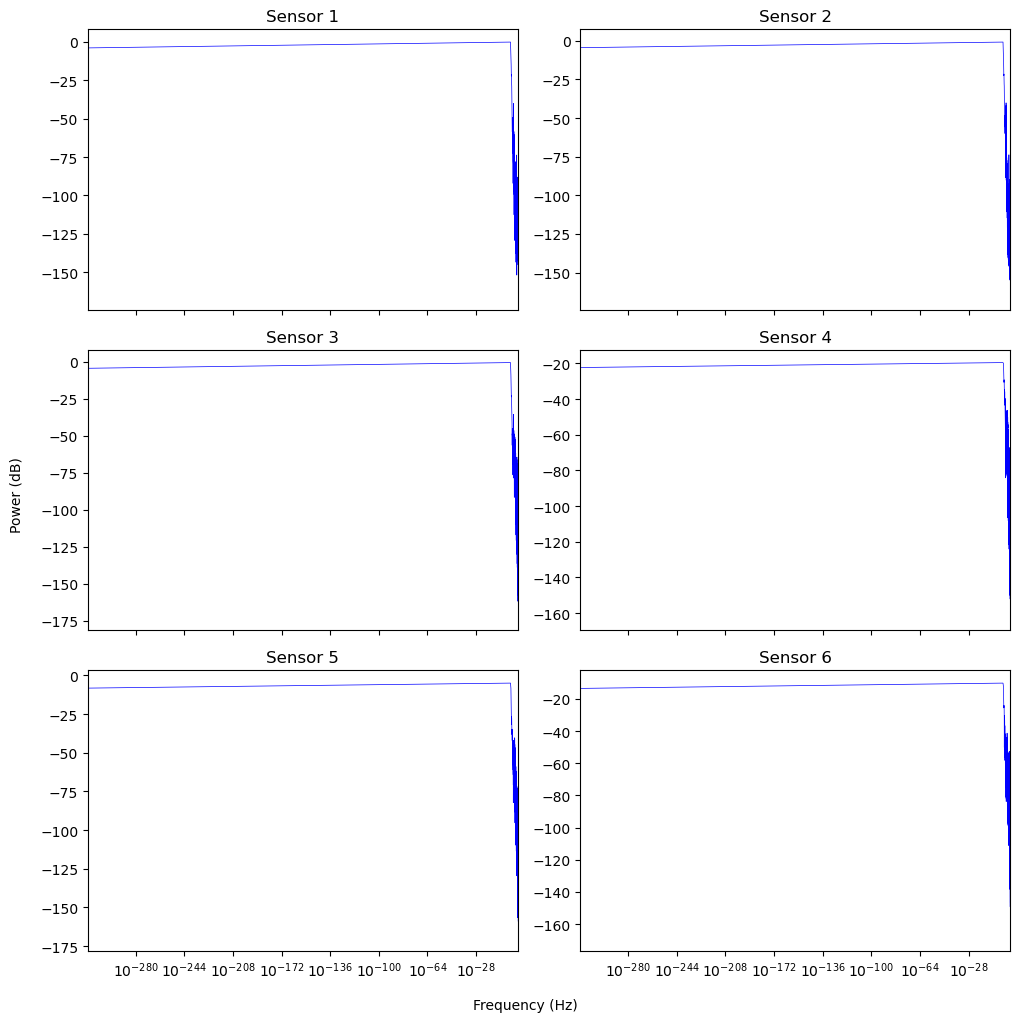

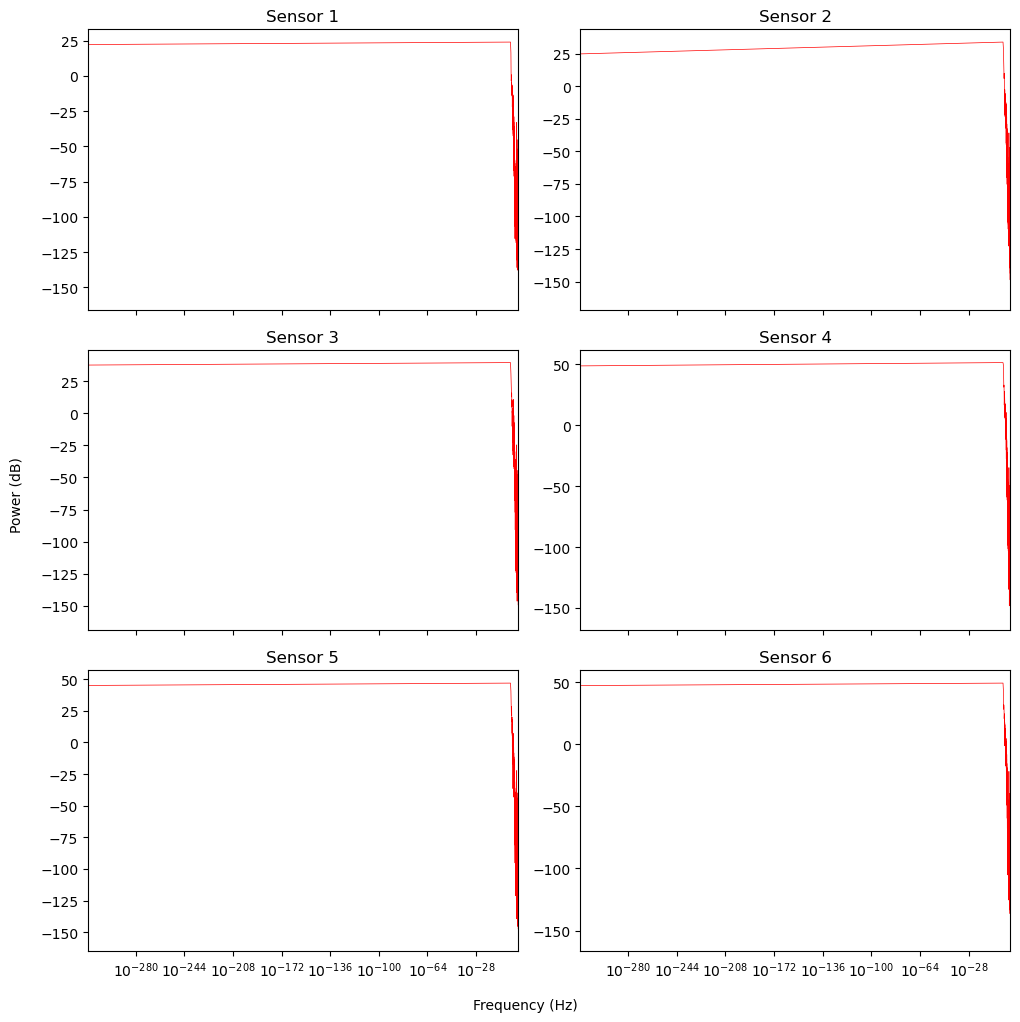

In [41]:
# Spectral Analysis
# %matplotlib qt
%matplotlib inline
analysis.plot_static(Pxx[0], Pxx[1], "Frequency (Hz)", "Power (dB)", plots_shape=(num_sens//2, 2), color='b', x_axis_type='log')
analysis.plot_static(Txx[0], Txx[1], "Frequency (Hz)", "Power (dB)", plots_shape=(num_sens//2, 2), color='r', x_axis_type='log')

## Spectrogram

For a more detailed analysis, should run this. 

Obtaining spectogram

In [37]:
import scipy.fft as fft
# FFT on Data
# Pick a sensor
sen:int = 1
data = Pressure[sen]
spec = analysis.spectrogram(data, window=20)

c:\Users\akyap\OneDrive\Documents\Academics\Research\LDEO Geysers\files\python\BinaryFileUnpack.py:361: ComplexWarning: Casting complex values to real discards the imaginary part
  spec[t-1][i][1] = db_spec[j]
c:\Users\akyap\OneDrive\Documents\Academics\Research\LDEO Geysers\files\python\BinaryFileUnpack.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  spec[t-1, :, 1] = db_spec


Plotting Spectrum

C:\Users\akyap\AppData\Local\Temp\ipykernel_26348\150131964.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


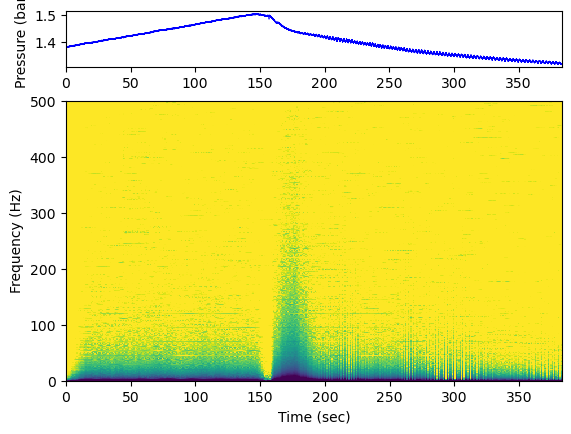

In [38]:
# %matplotlib qt
%matplotlib inline

fig, ax = plt.subplots(2, 1, height_ratios=[1, 5], sharex=False)
ax[0].plot(analysis.time[:-1], analysis.P[sen, :-1], color='blue', linewidth=0.5)
ax[0].set_ylabel('Pressure (bar)')
ax[0].set_xlim((0, analysis.time[-1]))

ax[1].set_xlabel('Time (sec)')
ax[1].set_ylabel('Frequency (Hz)')
ax[1].pcolormesh(np.arange(int(analysis.time[-1])+1), spec[0, :, 0], spec[:, :-1, 1].T, cmap='viridis_r', vmin=-5, vmax=10, shading='flat')
ax[1].set_ylim(0, 500)

fig.show()

## Plotting Pressure against Temperature Data for Hot Water Eruption Cycles

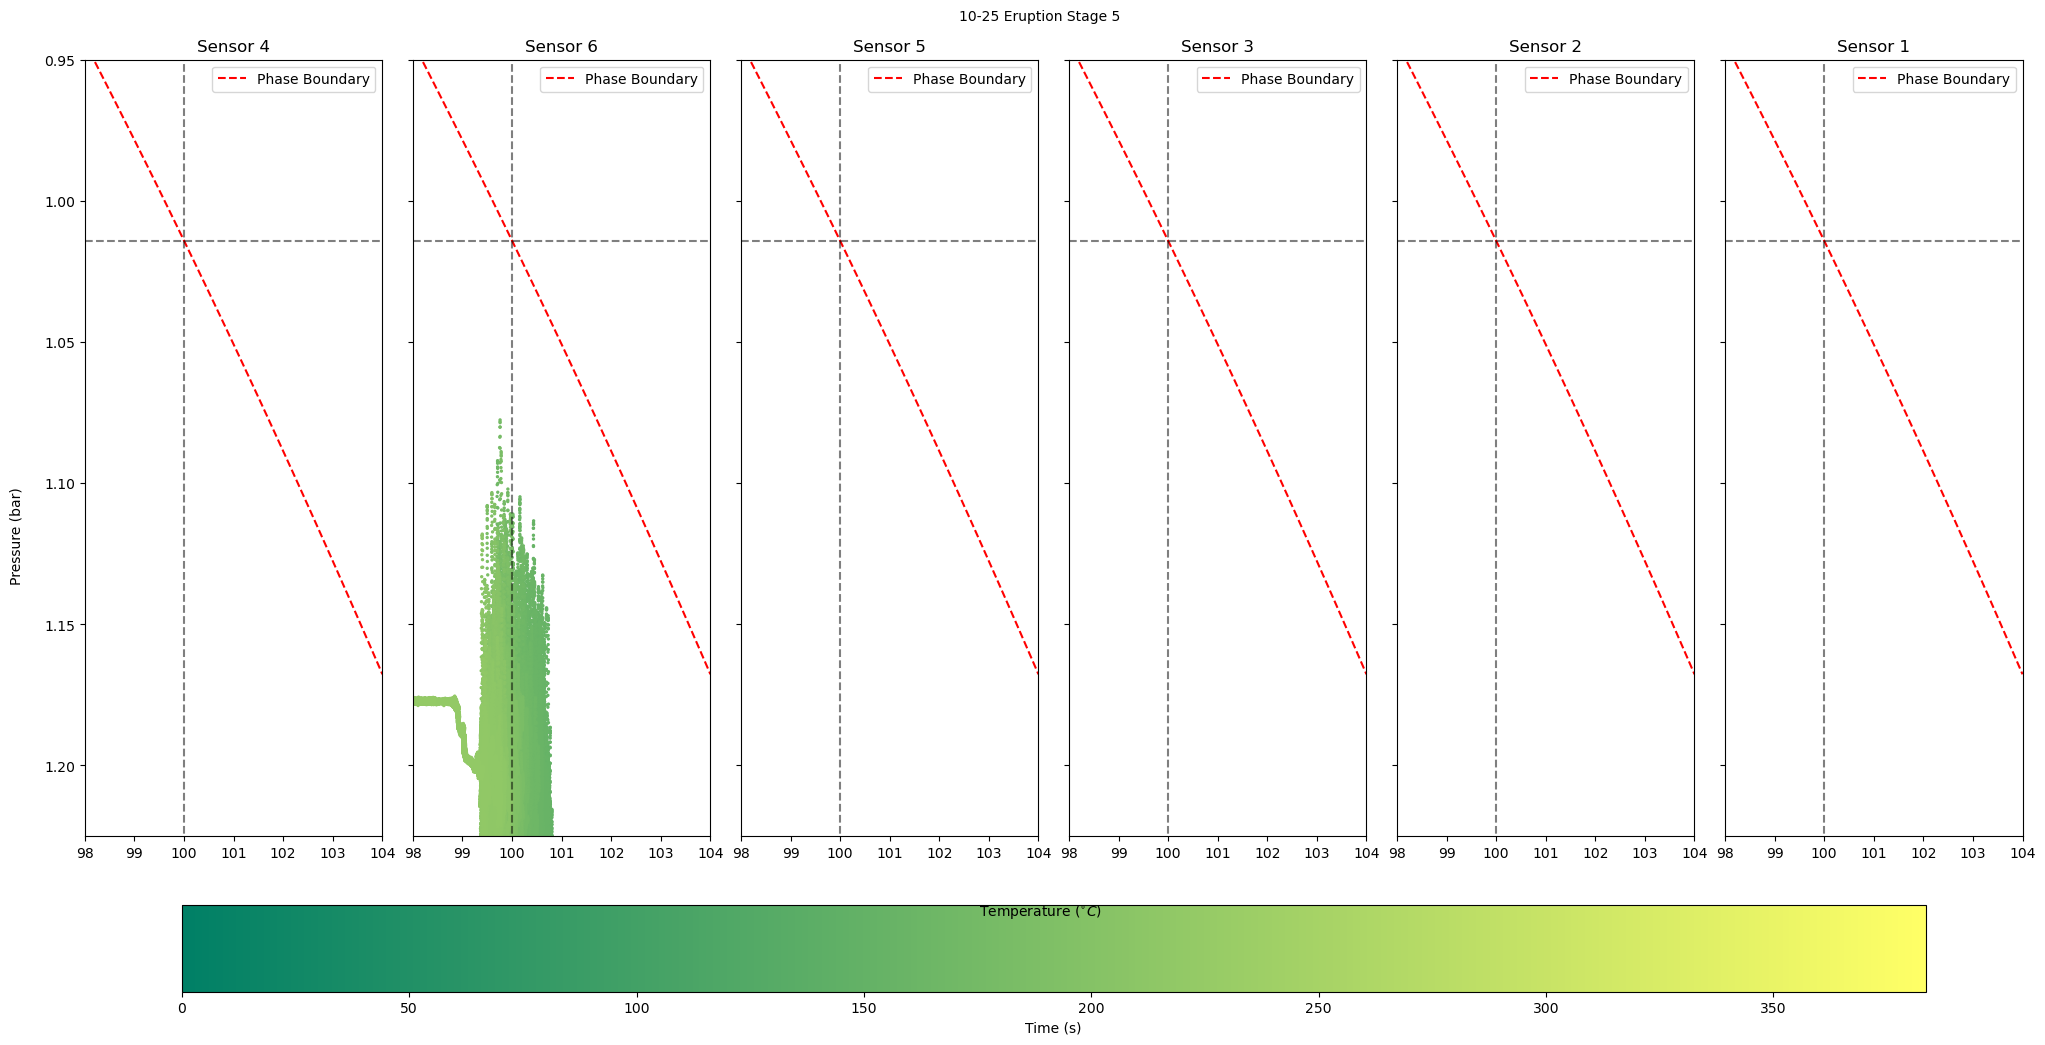

In [39]:
# %matplotlib qt
%matplotlib inline
analysis.plot_eruption_PT(show_phase_boundaries=True, title=f"10-25 Eruption Stage 4", ordering=[3, 5, 4, 2, 1, 0], savefig=False, times=times)